# Neural Spiking Data Analysis for Transcranial Focused Ultrasound Stimulation
## Dandiset 000945

**⚠️ IMPORTANT: This notebook was AI-generated with human supervision and has not been fully verified. Users should exercise caution when interpreting the code or results. Please verify analyses independently.**

This notebook demonstrates how to work with the neural recording data from transcranial focused ultrasound stimulation experiments in awake rat somatosensory cortex.

## Dataset Overview

This dataset contains neural recordings from the somatosensory cortex of awake head-fixed rats during transcranial focused ultrasound stimulation. Key experimental details:

* 10 male rats implanted with 32-channel NeuroNexus electrodes (Model: A1x32-Poly3-10mm-50-177-Z32)
* Stimulation delivered using 128-element random array ultrasound transducer
* Parameters tested:
    * PRFs (Pulse Repetition Frequencies): 30, 300, 1500, 3000, and 4500 Hz
    * Pulse duration: 200 microseconds
    * Ultrasound duration: 67 ms
* Trial structure:
    * 500 trials per recording
    * Trials delivered every ~2.5s with 10% jitter
* Neural data includes:
    * Spike times for sorted units
    * Cell type labels (RSU = Regular Spiking Unit, FSU = Fast Spiking Unit)

## Loading and Exploring the Data

First, let's load an example recording and examine its contents. We'll use the `lindi` library to access the remote NWB files efficiently.

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt

# Load an example file (30 Hz PRF condition)
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/000945/assets/a4e04662-e4cb-49f3-9076-41e04e833a11/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

print("Basic Information:")
print(f"Session Description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject Age: {nwb.subject.age}")
print(f"Subject Species: {nwb.subject.species}")

Basic Information:
Session Description: Awake S1 Stimulation by tFUS
Subject ID: BH497
Subject Age: P24W
Subject Species: Rattus norvegicus


## Understanding Data Structure

The NWB files contain several key components:
1. Trial timing information
2. Unit spike times and cell type labels
3. Electrode information

Let's examine each:

In [2]:
# Get trial information
trials = nwb.intervals["trials"]
trial_starts = trials["start_time"].data[:]  # Trial start times
trial_stops = trials["stop_time"].data[:]    # Trial end times
trial_durations = trial_stops - trial_starts

print("\nTrial Information:")
print(f"Number of trials: {len(trial_starts)}")
print(f"Mean trial duration: {np.mean(trial_durations):.3f} seconds")
print(f"Mean interval between trials: {np.mean(np.diff(trial_starts)):.3f} seconds")

# Get unit information
units = nwb.units
unit_ids = units["id"].data[:]
cell_types = units["celltype_label"].data[:]  # 1 = RSU, 2 = FSU

print("\nUnit Information:")
print(f"Total number of units: {len(unit_ids)}")
print(f"Number of RSUs: {np.sum(cell_types == 1)}")
print(f"Number of FSUs: {np.sum(cell_types == 2)}")


Trial Information:
Number of trials: 500
Mean trial duration: 2.200 seconds
Mean interval between trials: 2.500 seconds

Unit Information:
Total number of units: 64
Number of RSUs: 32
Number of FSUs: 32


## Example Analysis: Computing and Visualizing PSTHs

Here we'll demonstrate how to:
1. Align spike times to trial onsets
2. Compute peri-stimulus time histograms (PSTHs)
3. Compare responses between cell types

Note: We'll work with a subset of trials to keep computation efficient when loading remote data.

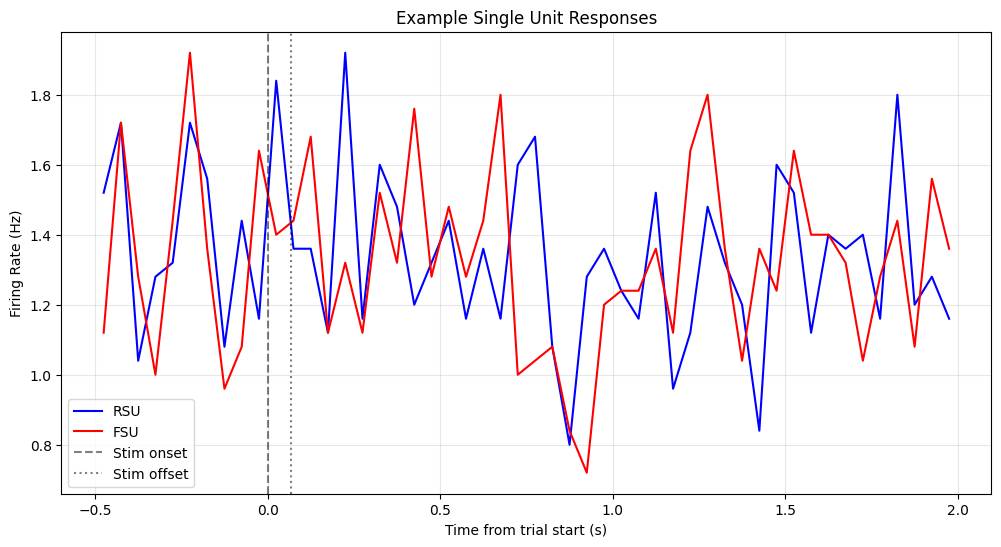

In [3]:
def compute_psth(spike_times, trial_times, window=[-0.5, 2.0], bin_size=0.05):
    """
    Compute PSTH for given spike times aligned to trial times.
    
    Parameters:
    -----------
    spike_times : array-like
        Timestamps of spikes
    trial_times : array-like
        Trial start times to align to
    window : list
        Time window around trial start [start, end] in seconds
    bin_size : float
        Size of time bins in seconds
    
    Returns:
    --------
    hist : array
        PSTH in Hz
    bin_centers : array
        Centers of time bins
    """
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2
    psth = np.zeros((len(trial_times), len(bins)-1))
    
    # Use first 50 trials for demonstration
    for i, trial_time in enumerate(trial_times[:50]):
        aligned_spikes = spike_times - trial_time
        mask = (aligned_spikes >= window[0]) & (aligned_spikes < window[1])
        if np.sum(mask) > 0:
            psth[i], _ = np.histogram(aligned_spikes[mask], bins=bins)
            
    return np.mean(psth, axis=0) / bin_size, bin_centers

# Create figure
plt.figure(figsize=(12, 6))

# Compute and plot PSTH for example units
for i in range(2):  # Plot first RSU and first FSU
    if i == 0:
        unit_idx = np.where(cell_types == 1)[0][0]  # First RSU
        color = 'blue'
        label = 'RSU'
    else:
        unit_idx = np.where(cell_types == 2)[0][0]  # First FSU
        color = 'red'
        label = 'FSU'
    
    # Get spike times for this unit
    spike_times = units["spike_times"][unit_idx][:]
    
    # Compute PSTH
    psth, bin_centers = compute_psth(spike_times, trial_starts)
    
    # Plot
    plt.plot(bin_centers, psth, color=color, label=label)

plt.axvline(x=0, color='k', linestyle='--', alpha=0.5, label='Stim onset')
plt.axvline(x=0.067, color='k', linestyle=':', alpha=0.5, label='Stim offset')
plt.xlabel('Time from trial start (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Example Single Unit Responses')
plt.legend()
plt.grid(True, alpha=0.3)

## Working with Different PRF Conditions

To analyze responses across different PRF conditions, you would:
1. Load recordings for each PRF condition
2. Compute response metrics (e.g., change in firing rate)
3. Compare across conditions

Here's how to get the list of recordings for a subject:

In [4]:
# Example code to list recordings
from glob import glob

print("Files are organized by subject, with each recording using a different PRF:")
print("PRFs tested: 30, 300, 1500, 3000, and 4500 Hz")
print("\nExample path format:")
print("sub-SUBJECTID/sub-SUBJECTID_ses-TIMESTAMP_ecephys.nwb")

Files are organized by subject, with each recording using a different PRF:
PRFs tested: 30, 300, 1500, 3000, and 4500 Hz

Example path format:
sub-SUBJECTID/sub-SUBJECTID_ses-TIMESTAMP_ecephys.nwb


## Research Applications

This dataset can be used to investigate:

1. Frequency-dependent effects of ultrasound stimulation on neural activity
2. Different response properties between cell types (RSUs vs FSUs)
3. Temporal dynamics of neural responses to ultrasound stimulation

When analyzing the data, consider:
* Using appropriate temporal windows for baseline and response periods
* Analyzing single-unit responses as well as population effects
* Accounting for potential artifacts or non-neural signals
* Comparing responses across different PRF conditions systematically

## Additional Notes

* The dataset includes recordings from awake and some anesthetized conditions for comparison
* Data was collected at multiple time points (8-10 months and 12 months)
* Cell type labels are included (RSU vs FSU)
* Files follow standard NWB format conventions